#1. SET *UP*


Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

we will run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf


device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. we install other usefull libraries as well. and then we import what we need to go on in these tasks.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup , Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, accuracy_score
import time
import datetime
import random

# 2. Loading Dataset

First we upload the data set to the google colab.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ssh_attacks.parquet to ssh_attacks.parquet


We load the dataset and print the dimension of the dataset. it contains 233035 rows and 4 columns.

In [ ]:
df = pd.read_parquet('ssh_attacks.parquet')

# Print the shape of the dataframe
print("Shape of the dataframe:", df.shape)

Shape of the dataframe: (233035, 4)


In [ ]:
# Taking a subset of the data
df = df.sample(n=100000, random_state=17)

# Preprocessing: Convert labels to binary columns for each intent
intents = ['Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless']

for intent in intents:
    df[intent] = df['Set_Fingerprint'].apply(lambda x: 1 if intent in x else 0)

# Preparation of the dataset for sequence classification
df['labels'] = df.apply(lambda row: [row[intent] for intent in intents], axis=1)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=17)

print("Shape of the dataframe:", df.shape)

Shape of the dataframe: (100000, 12)


# 3. Tokenization & Input Formatting

In this section, we’ll transform our dataset into the format that BERT can be trained on. Before we can do that, though, we need BERT’s formatting requirements.

We are required to:

Add special tokens to the start and end of each sentence. Pad & truncate all sentences to a single constant length. Explicitly differentiate real tokens from padding tokens with the “attention mask”. The “Attention Mask” is simply an array of 1s and 0s indicating which tokens are padding and which aren’t

For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
#lists of sentences and their labels
sentences = df.full_session.values
labels = df.labels.values

In [ ]:
from transformers import BertTokenizer


print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_len = 0
max_sequence_length = 128


for sent in sentences:


    input_ids = tokenizer.encode(sent, add_special_tokens=True, max_length=max_sequence_length, truncation=True)


    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Loading BERT tokenizer...
Max sentence length:  128


In [ ]:
# function to tokenize the text and create attention masks
def tokenize_function(sentences, labels, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,                      # Sentence to encode.
            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
            max_length=max_length,     # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',       # Return pytorch tensors.
            truncation=True,
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels, dtype=torch.float16)


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT–the below cell will download this for us. We’ll be using the “uncased” version here.

In [ ]:
# Tokenize the training and test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_inputs, train_masks, train_labels = tokenize_function(train_df.full_session.values, train_df[intents].values, tokenizer, max_length=128)
test_inputs, test_masks, test_labels = tokenize_function(test_df.full_session.values, test_df[intents].values, tokenizer, max_length=128)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
#DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 4. Train Our Classification Model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

Here we use a custome class. "BertForMultiLabelSequenceClassification" is a custom implementation that extends BertForSequenceClassification from the HuggingFace transformers library. It is designed to handle multi-label classification tasks, where each instance can belong to multiple classes simultaneously. The class inherits from BertForSequenceClassification, which means it gains all the properties and methods of that base class.

"BCEWithLogitsLoss" is the loss function used here. This stands for Binary Cross-Entropy with Logits Loss, which is suitable for multi-label classification. It combines a sigmoid layer and binary cross-entropy loss in a single class, making it useful for training models where each instance can have multiple binary labels.

The forward method defines how the input data passes through the model. This is where the main computations of the model occur.

BERT Outputs: The BERT model processes the inputs and produces several outputs:

outputs[0]: The last hidden state of the sequence.
outputs[1]: The pooled output (i.e., the representation of the [CLS] token).
Dropout: The pooled output is passed through a dropout layer. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.

Classification Layer: The dropout output is then passed through a classification layer to obtain the logits. These logits are the raw, unnormalized scores for each class.

he method returns a dictionary containing the computed loss (if labels are provided) and the logits. The logits can be used to make predictions, and the loss is used during training to update the model's weights.

In [ ]:
from torch.nn import BCEWithLogitsLoss

class BertForMultiLabelSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.loss_fct = BCEWithLogitsLoss()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels.float())

        return {"loss": loss, "logits": logits}

model = BertForMultiLabelSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(intents),
    output_attentions=False,
    output_hidden_states=False,
)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * 3

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


the train function trains the BERT model for one epoch.

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def train(model, optimizer, scheduler, train_dataloader, device):
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Elapsed: {elapsed}.')

        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs["loss"]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    return avg_train_loss

def evaluate(model, test_dataloader, device):
    model.eval()

    total_eval_accuracy = 0
    total_eval_f1 = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs["loss"]
        logits = outputs["logits"]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.where(logits >= 0.5, 1, 0)

        total_eval_accuracy += accuracy_score(label_ids, pred_flat)
        total_eval_f1 += f1_score(label_ids, pred_flat, average='weighted', zero_division=1)  # Adjusted here

    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_f1 = total_eval_f1 / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)

    return avg_val_loss, avg_val_accuracy, avg_val_f1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 3

training_stats = []

Here we tran and Plot the Learning Curve and Training and Validation Loss

Epoch 1/3
Training...
Batch 100 of 2500. Elapsed: 0:01:11.
Batch 200 of 2500. Elapsed: 0:02:20.
Batch 300 of 2500. Elapsed: 0:03:29.
Batch 400 of 2500. Elapsed: 0:04:38.
Batch 500 of 2500. Elapsed: 0:05:47.
Batch 600 of 2500. Elapsed: 0:06:57.
Batch 700 of 2500. Elapsed: 0:08:06.
Batch 800 of 2500. Elapsed: 0:09:15.
Batch 900 of 2500. Elapsed: 0:10:23.
Batch 1000 of 2500. Elapsed: 0:11:32.
Batch 1100 of 2500. Elapsed: 0:12:41.
Batch 1200 of 2500. Elapsed: 0:13:50.
Batch 1300 of 2500. Elapsed: 0:15:00.
Batch 1400 of 2500. Elapsed: 0:16:09.
Batch 1500 of 2500. Elapsed: 0:17:18.
Batch 1600 of 2500. Elapsed: 0:18:27.
Batch 1700 of 2500. Elapsed: 0:19:36.
Batch 1800 of 2500. Elapsed: 0:20:45.
Batch 1900 of 2500. Elapsed: 0:21:54.
Batch 2000 of 2500. Elapsed: 0:23:03.
Batch 2100 of 2500. Elapsed: 0:24:12.
Batch 2200 of 2500. Elapsed: 0:25:21.
Batch 2300 of 2500. Elapsed: 0:26:30.
Batch 2400 of 2500. Elapsed: 0:27:39.
Average training loss: 0.030647125404141842
Training epoch took: 0:28:49
Ev

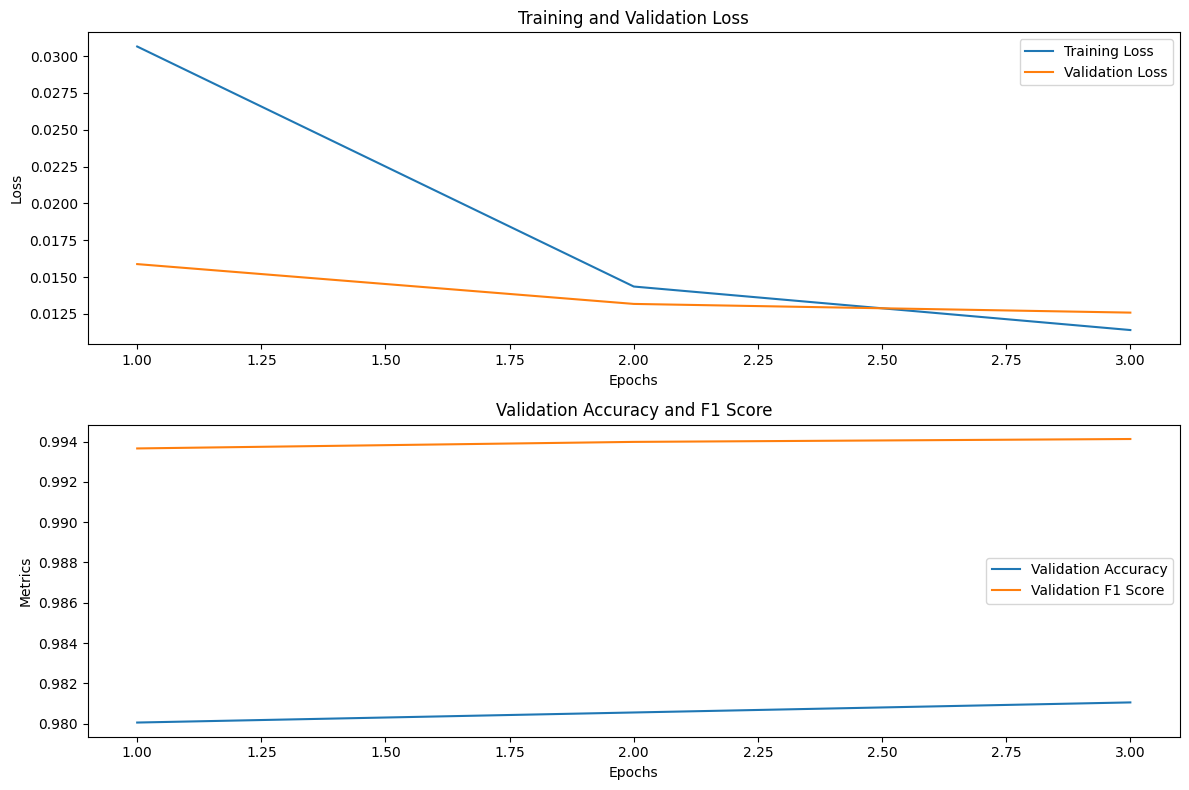

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_accuracies = []
val_f1s = []

# Training loop
for epoch_i in range(0, epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    print('Training...')

    t0 = time.time()
    avg_train_loss = train(model, optimizer, scheduler, train_dataloader, device)
    training_time = format_time(time.time() - t0)

    train_losses.append(avg_train_loss)

    print(f'Average training loss: {avg_train_loss}')
    print(f'Training epoch took: {training_time}')

    print('Evaluating...')
    t0 = time.time()
    avg_val_loss, avg_val_accuracy, avg_val_f1 = evaluate(model, test_dataloader, device)
    validation_time = format_time(time.time() - t0)

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    val_f1s.append(avg_val_f1)

    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation Accuracy: {avg_val_accuracy}')
    print(f'Validation F1 Score: {avg_val_f1}')
    print(f'Validation took: {validation_time}')


epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

#training and validation loss plots
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# validation accuracy and F1 score plots
plt.subplot(2, 1, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Accuracy and F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
